# Summary

This Jupyter Notebook simulates photon transport using OpenMC for a setup involving a Cs-137 source, a CdTe detector, air, and a concrete wall. The geometry is defined with spherical and parallelepiped regions, and the simulation is configured in fixed source mode with photon transport enabled.

Key steps include:
- **Material and geometry definition:** Materials (Cs-137, CdTe, air, concrete) and regions (source, detector, wall, air) are set up.
- **Source configuration:** A point source emitting 662 keV photons isotropically is defined.
- **Tallies:** 
    - A cell tally measures photon flux in the detector.
    - A mesh tally records spatial flux distribution in the XY plane.
    - An energy deposition tally captures the pulse-height spectrum in the detector.
- **Simulation settings:** The simulation runs for 100 batches with 100,000 particles per batch.
- **Results:** 
    - The average photon flux in the detector is computed and saved.
    - The mesh tally is visualized to show spatial flux distribution.
    - The pulse-height spectrum is plotted, highlighting key features such as the full absorption peak (662 keV), retrodiffusion peak (184 keV), and Compton edge (478 keV).

This workflow enables detailed analysis of photon interactions and detector response in a shielded environment.

In [1]:
# -*- coding: utf-8 -*-
import openmc
import os
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys
from PIL import Image
import numpy as np

In [2]:
CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[3]
sys.path.append(str(project_root))
from parameters.parameters_paths import PATH_TO_CROSS_SECTIONS
from parameters.parameters_materials import CS137_MATERIAL, CDTE_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL
from src.utils.pre_processing.pre_processing import remove_previous_results, parallelepiped, plot_geometry, mesh_tally_plane
from src.utils.post_preocessing.post_processing import load_mesh_tally
os.environ["OPENMC_CROSS_SECTIONS"] = PATH_TO_CROSS_SECTIONS

In [3]:
# Définition des matériaux
materials = openmc.Materials([CS137_MATERIAL, CDTE_MATERIAL, AIR_MATERIAL, CONCRETE_MATERIAL])

In [4]:
# Surfaces
sphere = openmc.Sphere(r=1.0, surface_id=1)
detector = openmc.Sphere(x0=30., r=10.0, surface_id=2)
outer_boundary = openmc.Sphere(r=200.0, surface_id=3, boundary_type='vacuum')

# Create concrete wall using parallelepiped
wall_region = parallelepiped(-40, -20, -50, 50, -50, 50, surface_id_start=10)
wall_cell = openmc.Cell(name="concrete_wall", fill=CONCRETE_MATERIAL, region=wall_region)

In [5]:
# Cells
source_cell = openmc.Cell(name="source_cell")
source_cell.fill = CS137_MATERIAL
source_cell.region = -sphere

detector_cell = openmc.Cell(name="detector_cell")
detector_cell.fill = CDTE_MATERIAL
detector_cell.region = -detector

# Air cell (everything else inside the outer boundary, minus source, detector, and wall)
outer_boundary_cell = -outer_boundary
void_region = outer_boundary_cell & ~source_cell.region & ~detector_cell.region & ~wall_region
void_cell = openmc.Cell(name="air_cell", fill=AIR_MATERIAL, region=void_region)

universe = openmc.Universe(cells=[source_cell, detector_cell, wall_cell, void_cell])
geometry = openmc.Geometry(universe)

In [6]:
geometry.export_to_xml()
materials.export_to_xml()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

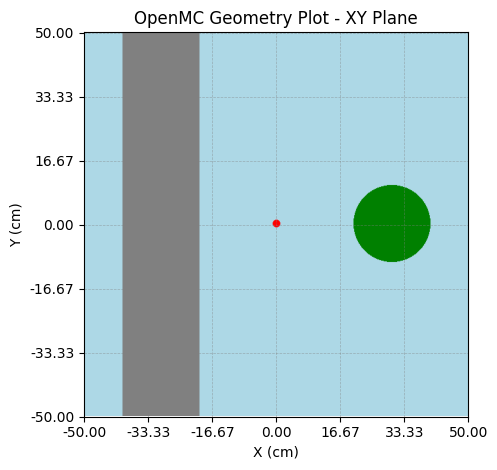

In [7]:
plot_geometry(materials=materials, width=100, height=100)

In [8]:
# Création de la source
source = openmc.Source()
source.space = openmc.stats.Point((0, 0, 0))
source.energy = openmc.stats.Discrete([661_700], [1.0])  # Énergie du photon de 662 keV pour Cs137
source.angle = openmc.stats.Isotropic()
source.particle = "photon"

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [ ]:
tallies = openmc.Tallies([])

# Création des tallies
mesh_tally = mesh_tally_plane(plane="xy", particule_type="photon")
tallies.append(mesh_tally)

# Tally pour le spectre d'énergie déposée dans le détecteur
energy_bins = np.linspace(1e-3, 1.0e6, 500)
energy_filter = openmc.EnergyFilter(energy_bins)
cell_filter = openmc.CellFilter(detector_cell)

energy_dep_tally = openmc.Tally(name="pulse-height")
energy_dep_tally.filters = [cell_filter, energy_filter]
energy_dep_tally.scores = ["pulse-height"]
tallies.append(energy_dep_tally)

ValueError: Unable to set "filter bin" to "neutrons" since it is not in "{'electron', 'photon', 'neutron', 'positron'}"

In [ ]:
# Configuration de la simulation
settings = openmc.Settings()
batches_number = 100
settings.batches = batches_number
settings.particles = 10**5
settings.source = source
settings.photon_transport = True
settings.run_mode = "fixed source"
settings.verbose = True

In [ ]:
# Export des fichiers nécessaires pour la simulation
materials.export_to_xml()
geometry.export_to_xml()
settings.export_to_xml()
tallies.export_to_xml()

/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/Users/simonfoucambert/miniconda3/envs/openmc-arm/lib/python3.11/site-packages/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)


In [ ]:
# Plot geometry in XY
plot = openmc.Plot()
plot.origin = (0, 0, 0)
plot.width = (120, 120)
plot.pixels = (600, 600)
plot.color_by = 'material'
plot.basis = 'xy'

plots = openmc.Plots([plot])
plots.export_to_xml()
openmc.plot_geometry()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
# Exécution de la simulation
remove_previous_results(batches_number)
os.environ["OMP_NUM_THREADS"] = "1"
openmc.run()
print("Calcul fini")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [ ]:
# Analyse des résultats
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")
tally = sp.get_tally(name="detector_tally")
flux_mean = tally.mean.flatten()
flux_std_dev = tally.std_dev.flatten()

print("Average flux :", flux_mean[0]/ source.strength)
print("Std-dev :", flux_std_dev[0]/ source.strength)

results = {
    "flux_mean": float(flux_mean[0] / source.strength),
    "flux_std_dev": float(flux_std_dev[0] / source.strength)
}

with open(CWD / "results.json", "w") as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

Average flux : 0.0981735304141118
Std-dev : 0.00022042014419934678


In [ ]:
# Affichage du tally maillage (mesh tally)
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")
mesh_tally = sp.get_tally(name='flux_mesh')

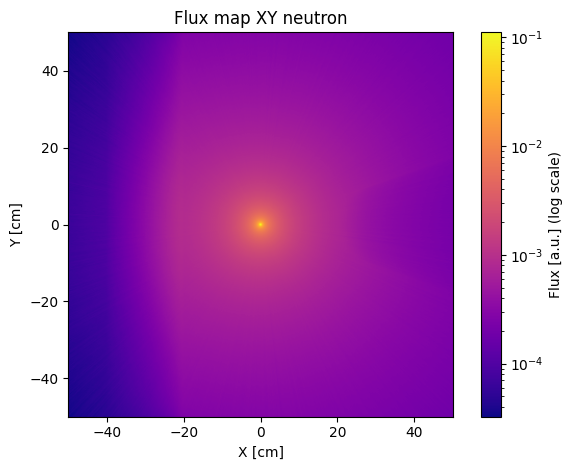

In [ ]:
load_mesh_tally(statepoint_file=sp, cwd = CWD, name_mesh_tally="flux_mesh",
                plane = "xy", upper_right=(50, 50), lower_left=(-50, -50),
                zoom_x=(-50, 50), zoom_y=(-50, 50))

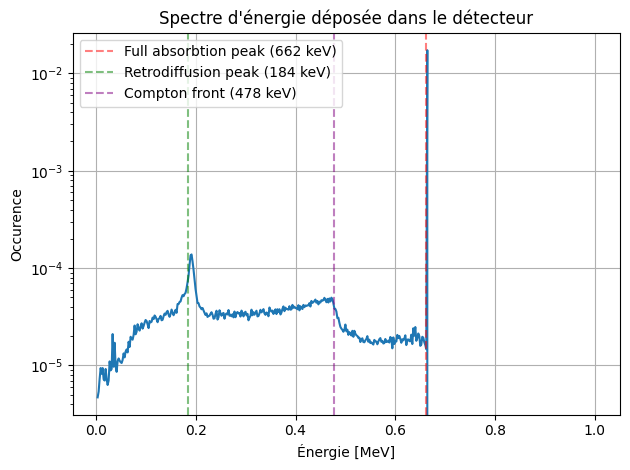

In [ ]:
# Affichage du spectre d'énergie déposée
sp = openmc.StatePoint(f"statepoint.{batches_number}.h5")
tally = sp.get_tally(name="pulse-height")
pulse_height_values = tally.get_values(scores=['pulse-height']).flatten()

# Récupération des énergies moyennes par bin (approximation)
energy_bin_centers = energy_bins[1:] + 0.5 * (energy_bins[1] - energy_bins[0])
energy_bin_centers /= 1e6
# Moyenne et écart-type de l'énergie déposée
spectrum = tally.mean.flatten()
spectrum_std = tally.std_dev.flatten()

# Tracé
plt.figure()
plt.semilogy(energy_bin_centers, spectrum)
plt.axvline(x=0.662, color='red', linestyle='--', label='Full absorbtion peak (662 keV)', alpha=0.5)
plt.axvline(x=0.184, color='green', linestyle='--', label='Retrodiffusion peak (184 keV)', alpha=0.5)
plt.axvline(x=0.478, color="purple", linestyle='--', label='Compton front (478 keV)', alpha=0.5)
plt.xlabel("Énergie [MeV]")
plt.ylabel("Occurence")
plt.title("Spectre d'énergie déposée dans le détecteur")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(CWD / "spectrum.png")
plt.show()